In [1]:
import time
#time.sleep(60*60*8)

import numpy as np
from numpy import asarray
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.layers import Dense, Dropout, Flatten, LeakyReLU, Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.python.client import device_lib
import tensorflow.compat.v1.keras.backend as K
import tensorflow.compat.v1 as tf1

import cv2
import matplotlib.pyplot as plt
from PIL import Image
import imgaug.augmenters as iaa
from skimage import data, color, img_as_ubyte ,io
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage.color import rgb2gray,rgba2rgb

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, classification_report,roc_auc_score,ConfusionMatrixDisplay
from sklearn.utils import class_weight
import imutils
import os
import random
from tqdm import tqdm
import urllib.request


tf.keras.backend.clear_session()
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
strategy = tf.distribute.MirroredStrategy()

from classification_models.tfkeras import Classifiers
Resnext, preprocess_input = Classifiers.get('resnext50')
from vit_keras import vit


2024-03-18 14:21:27.116821: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2024-03-18 14:21:29.194253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38223 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c7:00.0, compute capability: 8.0
2024-03-18 14:21:29.208803: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38223 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c7:00.0, compute capability: 8.0
/mnt/louisayu/nfs_share2/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

In [204]:
def decode(a):
    if a =='A' or a =='2':
        return int(2)
    elif  a=='B' or a == '1':
        return int(1)
    elif a=='C' or a =='0':
        return int(0)
    else:
        return int(a)

    
def to_categorical(y, num_classes=None, dtype='float32'):

 
    y = np.array(y, dtype='int')

    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.ravel()

    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]

    categorical = np.zeros((n, num_classes), dtype=dtype)

    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

def label_smoothing(y, num_classes=3, dtype='float32',factor=0.3):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
         input_shape = tuple(input_shape[:-1])

    y = y.ravel()
    if not num_classes:
         num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)

    for i in np.arange(n):
        if y[i]-1>=0 and y[i]+1<num_classes:
            categorical[np.arange(n), y] = 1-factor
            categorical[i, y[i]-1] = factor/2
            categorical[i, y[i]+1] = factor/2
        elif y[i]-1>=0 and y[i]+1>=num_classes:
            categorical[np.arange(n), y] = 1-factor
            categorical[i, y[i]-1] = factor
        else:
            categorical[np.arange(n), y] = 1-factor
            categorical[i, y[i]+1] = factor
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical
        

In [518]:
        
fine= pd.read_csv('/mnt/louisayu/nfs_share2/embryo/code/em_aug/grading/fresh.csv')  
train=pd.read_csv("/mnt/louisayu/nfs_share2/embryo/code/em_aug/grading/Gardner_train_silver.csv")
test=pd.read_csv("/mnt/louisayu/nfs_share2/embryo/code/em_aug/grading/Gardner_test_gold_onlyGardnerScores.csv")

pixel=256
channels=3
NUM_CLASSES=5

fine_image=[]
fine_label=[]

train_image = []
train_label = []

test_image=[]
test_label=[]
testname=[]


for i in tqdm(range(fine.shape[0])):
    filename= "/mnt/louisayu/nfs_share2/embryo/preprocess_rec/"+fine['image'][i]
    if not fine['g3'][i]=='ND':
        try:
            im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im,(pixel,pixel))
            im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
            img = img_to_array(im)
            fine_label.append(decode(fine['g3'][i]))
            fine_image.append(img)
        except:
            print("fine:", filename)
        
for j in tqdm(range(train.shape[0])):
    filename= "/mnt/louisayu/nfs_share2/embryo/pubdata/"+train['Image'][j]
    if not train['g3'][j]=='ND':
        try:  
            im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im,(pixel,pixel))
            im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
            #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
            img = img_to_array(im)
            train_label.append(decode(train['g3'][j]))
            train_image.append(img)
        except:
            print("train:", filename)
                
for k in tqdm(range(test.shape[0])):
    filename= "/mnt/louisayu/nfs_share2/embryo/pubdata/"+test['Image'][k]
    if not test['g3'][k]=='NA' and not test['g3'][k]=='ND':
        try:   
            im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im,(pixel,pixel))
            im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
            #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
            img = img_to_array(im)
            test_label.append(decode(test['g3'][k]))
            test_image.append(img)
            testname.append(test['Image'][k])
        except:
            print("test:", filename)

 97%|██████████████████████████████████████████████████▋ | 463/475 [00:04<00:00, 311.98it/s][ WARN:0@70809.496] global loadsave.cpp:248 findDecoder imread_('/mnt/louisayu/nfs_share2/embryo/preprocess_rec/20200713 LYT.bmp'): can't open/read file: check file path/integrity
[ WARN:0@70809.549] global loadsave.cpp:248 findDecoder imread_('/mnt/louisayu/nfs_share2/embryo/preprocess_rec/20210329 AUYK.bmp'): can't open/read file: check file path/integrity
[ WARN:0@70809.549] global loadsave.cpp:248 findDecoder imread_('/mnt/louisayu/nfs_share2/embryo/preprocess_rec/20220501 LKM.jpg'): can't open/read file: check file path/integrity
100%|████████████████████████████████████████████████████| 475/475 [00:04<00:00, 115.83it/s]


fine: /mnt/louisayu/nfs_share2/embryo/preprocess_rec/20200713 LYT.bmp
fine: /mnt/louisayu/nfs_share2/embryo/preprocess_rec/20210329 AUYK.bmp
fine: /mnt/louisayu/nfs_share2/embryo/preprocess_rec/20220501 LKM.jpg


 22%|███████████▋                                         | 66/300 [00:00<00:01, 179.62it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/0113_02.png
test: /mnt/louisayu/nfs_share2/embryo/pubdata/0173_01.png
test: /mnt/louisayu/nfs_share2/embryo/pubdata/0176_03.png


 42%|█████████████████████▋                              | 125/300 [00:00<00:00, 184.29it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/215_01.png
test: /mnt/louisayu/nfs_share2/embryo/pubdata/215_03.png
test: /mnt/louisayu/nfs_share2/embryo/pubdata/307_01.png


 69%|███████████████████████████████████▋                | 206/300 [00:01<00:00, 179.72it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/428_01.png


 75%|███████████████████████████████████████             | 225/300 [00:01<00:00, 173.75it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/531_02.png
test: /mnt/louisayu/nfs_share2/embryo/pubdata/560_02.png


 93%|████████████████████████████████████████████████▌   | 280/300 [00:01<00:00, 170.85it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/678_01.png
test: /mnt/louisayu/nfs_share2/embryo/pubdata/781_05.png


100%|████████████████████████████████████████████████████| 300/300 [00:01<00:00, 177.21it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/835_05.png


In [4]:
a0= [x for x, y in list(enumerate(train_label)) if y ==0]
a1= [x for x, y in list(enumerate(train_label)) if y ==1]
a2= [x for x, y in list(enumerate(train_label)) if y ==2]

print("before aug, a0:",len(a0))
print("before aug, a1:",len(a1))
print("before aug, a2:",len(a2))    



before aug, a0: 47
before aug, a1: 525
before aug, a2: 1081


In [5]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)  
seq= iaa.Sequential([
    iaa.SomeOf((1, 3),
               [
    sometimes(iaa.CoarseSaltAndPepper(0.05, size_percent=(0.01, 0.1))),
    iaa.GammaContrast((0.1)),
    iaa.MotionBlur(k=15),
    sometimes(iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5))),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}), # translate by -20 to +20 percent (per axis)),
    iaa.pillike.EnhanceSharpness()],
            random_order=True)
])
seq1=iaa.Sequential([
    iaa.SomeOf((2, 3),
               [
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.GammaContrast((0.1)),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}), # translate by -20 to +20 percent (per axis)),
    iaa.pillike.EnhanceSharpness()],
            random_order=True)
])
    
    
img0=[]
for i in a0:
    img0.append(train_image[i].astype(np.uint8))
    
img1=[]
for i in a1:
    img1.append(train_image[i].astype(np.uint8))

img0seq = seq(images=img0)
train_image.extend(img0seq)
img0seq1=  seq1(images=img0) 
train_image.extend(img0seq1)  
for i in range(len(img0seq)):
    train_label.append(0)
for i in range(len(img0seq1)):
    train_label.append(0)
    

img1seq1 = seq1(images=img1)
train_image.extend(img1seq1)
for i in range(len(img1seq1)):
    train_label.append(1)
    
        
a0= [x for x, y in list(enumerate(train_label)) if y ==0]
a1= [x for x, y in list(enumerate(train_label)) if y ==1]
a2= [x for x, y in list(enumerate(train_label)) if y ==2]

print("after aug, a0:",len(a0))
print("after aug, a1:",len(a1))
print("after aug, a2:",len(a2))    



47 525
after aug, a0: 141
after aug, a1: 1050
after aug, a2: 1081


In [519]:
xtrain = np.array(train_image,dtype='float32')  
ytrain = np.array(train_label)
X_train, X_val, Y_train, Y_val = train_test_split(xtrain, ytrain, shuffle=True,random_state=42, test_size=0.15)

y_train= to_categorical(Y_train,3)
y_val=to_categorical(Y_val,3)


In [162]:
def ordinal_loss(y_true,y_pred):
    #y_true = tf.cast(y_true, dtype=tf.int256)
    weights= K.cast(K.abs(K.argmax(y_true,axis=1)-K.argmax(y_pred,axis=1)),dtype='float32')
    return (1+weights)*tf.keras.losses.categorical_crossentropy(y_true,y_pred)#

# with strategy.scope():
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'linear',
        pretrained = True,
        include_top = True,
        pretrained_top =True,)
        #classes = 3)

model = Sequential([
        layers.Input(shape=(pixel,pixel,channels),name='main_input'),
        layers.Resizing(224, 224),
        layers.RandomRotation(factor=(-0.2, 0.3)),
        layers.RandomZoom(height_factor=-0.1, width_factor=-0.1),
        layers.RandomFlip(mode="horizontal_and_vertical"),
        layers.BatchNormalization(),
        vit_model,
        layers.Dense(3,activation='softmax'),
    ],
    name = 'vision_transformer_te')

opt = tf.keras.optimizers.Adam(learning_rate=0.00003)
model.compile(optimizer=opt,  loss=ordinal_loss, metrics =['accuracy', tf.keras.metrics.AUC(multi_label = True)]) 

print(model.summary())


def get_callbacks():
    checkpoint_filepath = '/mnt/louisayu/nfs_share2/embryo/model_weights1/g3/ep{epoch:03d}_acc{val_accuracy:.4f}_val_loss{val_loss:.4f}.h5'
    return [
            EarlyStopping(monitor="val_accuracy", mode="max", patience = 10, verbose=1),
            
            ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.7, min_lr=1e-6, patience=7, verbose=1),
            
            ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", mode="max", save_weights_only=True) # save_best_only=True)
           ]

from sklearn.utils import class_weight
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

history=model.fit(X_train, y_train, batch_size= 32, validation_data=(X_val, y_val), epochs=80, verbose=2, shuffle=True,callbacks=get_callbacks(),class_weight=d_class_weights)

/mnt/louisayu/nfs_share2/anaconda3/envs/tf/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


Model: "vision_transformer_te"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_5 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_5 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_5 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
vit-b16 (Functional)         (None, 1000)              86567656  
_________________________________________________________________
dense_5 (Dense)              (None, 3)       

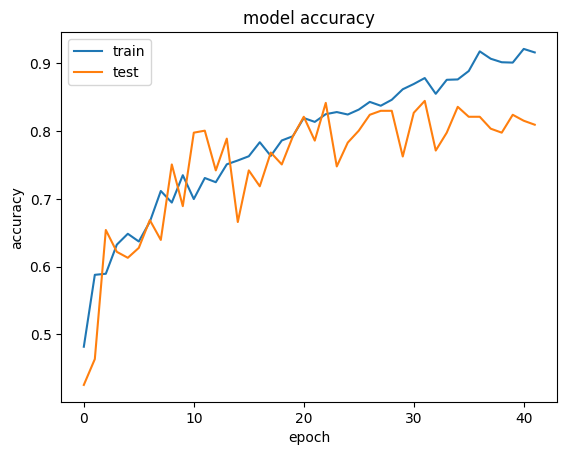

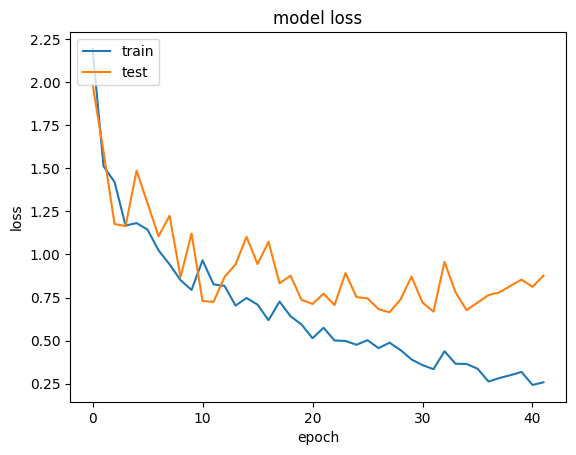

In [163]:
#Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    

roc_auc_score: 0.8388513278243996
f1_score: 0.7060616093805171
accuracy_score: 0.7136752136752137
              precision    recall  f1-score   support

           0       0.71      0.40      0.51        30
           1       0.61      0.62      0.61        82
           2       0.78      0.85      0.82       122

    accuracy                           0.71       234
   macro avg       0.70      0.62      0.65       234
weighted avg       0.71      0.71      0.71       234



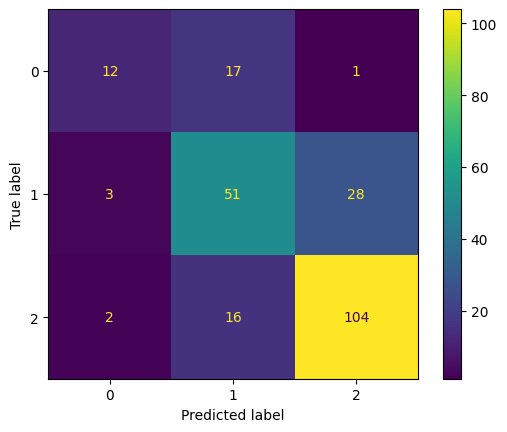

In [616]:

x_test = np.reshape(test_image,(len(test_label),pixel,pixel,channels))
y_test = np.reshape(test_label,(len(test_label),1))

y_prediction=model.predict(x_test)
score = roc_auc_score(y_test, y_prediction, multi_class='ovr')
print("roc_auc_score:", score)
y_prediction = np.argmax(y_prediction, axis=1)
print("f1_score:", f1_score(y_test, y_prediction, average='weighted'))   
ac=accuracy_score(y_test, y_prediction)
print("accuracy_score:", ac)
print(classification_report(y_test, y_prediction))

model.save('/mnt/louisayu/nfs_share2/embryo/model_weights1/g3/model/'+str(ac).replace('0.','')+'.h5')
cm=confusion_matrix(y_test, y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

    

In [586]:

ft_image=np.array((train_image+fine_image),dtype='float32')
ft_label=np.concatenate((to_categorical(train_label,3),label_smoothing(fine_label,3)),axis=0)

index = [i for i in range(len(ft_label))]
np.random.seed(27)
np.random.shuffle(index)
x_fine = ft_image[index]
y_fine = ft_label[index]
X_fine= np.reshape(x_fine,(len(x_fine),pixel,pixel,channels))

ftmodel=tf.keras.models.load_model("/mnt/louisayu/nfs_share2/embryo/model_weights1/g3/model/7136752136752137.h5",compile=False)

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
ftmodel.compile(optimizer=opt,  loss= ordinal_loss, metrics =['accuracy', tf.keras.metrics.AUC(multi_label = True, name="auc")]) 



def get_callbacks():
    checkpoint_filepath = '/mnt/louisayu/nfs_share2/embryo/model_weights1/g3/ep{epoch:03d}_acc{accuracy:.4f}_val_loss{loss:.4f}.h5'
    return [
            EarlyStopping(monitor="val_accuracy", mode="max", patience = 6, verbose=1, restore_best_weights=True),
            
            ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.7, min_lr=1e-6, patience=3, verbose=1),
            
            ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", mode="max", save_weights_only=True) # save_best_only=True)
           ]

y_integers = np.argmax(y_fine, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

history=ftmodel.fit(X_fine, y_fine, batch_size=64, epochs=50, verbose=2, shuffle=True,callbacks=get_callbacks(),class_weight=d_class_weights, validation_split=0.12)

{0: 9.694835680751174, 1: 0.8680117696511139, 2: 0.5731334998612267}
Epoch 1/50
29/29 - 23s - loss: 1.4499 - accuracy: 0.6632 - auc: 0.7583 - val_loss: 0.7793 - val_accuracy: 0.8065 - val_auc: 0.8624
Epoch 2/50
29/29 - 9s - loss: 1.0838 - accuracy: 0.6968 - auc: 0.7890 - val_loss: 0.8034 - val_accuracy: 0.7782 - val_auc: 0.8609
Epoch 3/50
29/29 - 10s - loss: 0.9959 - accuracy: 0.7111 - auc: 0.8001 - val_loss: 0.7463 - val_accuracy: 0.7984 - val_auc: 0.8654
Epoch 4/50
29/29 - 10s - loss: 0.9654 - accuracy: 0.7331 - auc: 0.8126 - val_loss: 0.7513 - val_accuracy: 0.7863 - val_auc: 0.8670
Epoch 5/50
29/29 - 9s - loss: 0.9154 - accuracy: 0.7303 - auc: 0.8268 - val_loss: 0.8686 - val_accuracy: 0.7782 - val_auc: 0.8615
Epoch 6/50
29/29 - 10s - loss: 0.8620 - accuracy: 0.7413 - auc: 0.8255 - val_loss: 0.7314 - val_accuracy: 0.7984 - val_auc: 0.8744
Epoch 7/50
29/29 - 10s - loss: 0.7959 - accuracy: 0.7567 - auc: 0.8354 - val_loss: 0.7340 - val_accuracy: 0.7903 - val_auc: 0.8772
Restoring model 

roc_auc_score: 0.8428917878685341
f1_score: 0.7259807483670307
accuracy_score: 0.7307692307692307
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        30
           1       0.65      0.59      0.62        82
           2       0.79      0.86      0.82       122

    accuracy                           0.73       234
   macro avg       0.70      0.68      0.69       234
weighted avg       0.72      0.73      0.73       234



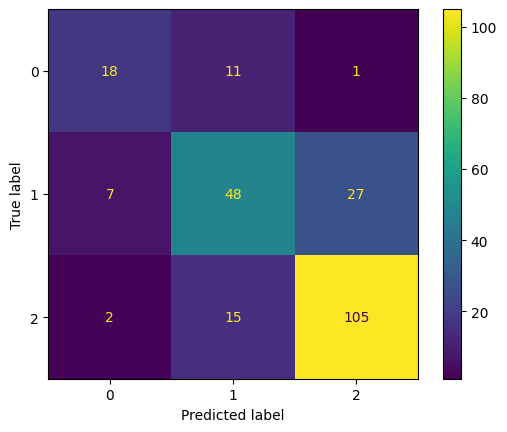

In [612]:

x_test = np.reshape(test_image,(len(test_label),pixel,pixel,channels))
y_test = np.reshape(test_label,(len(test_label),1))


y_prediction=ftmodel.predict(x_test)
score = roc_auc_score(y_test, y_prediction, multi_class='ovr')
print("roc_auc_score:", score)
y_prediction = np.argmax(y_prediction, axis=1)
print("f1_score:", f1_score(y_test, y_prediction, average='weighted'))   
ac=accuracy_score(y_test, y_prediction)
print("accuracy_score:", ac)
print(classification_report(y_test, y_prediction))


ftmodel.save('/mnt/louisayu/nfs_share2/embryo/model_weights1/g3/model/ft_'+str(ac).replace('0.','')+'.h5')
cm=confusion_matrix(y_test, y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [610]:

combine_image=np.array((train_image+fine_image),dtype='float32')
combine_label=np.concatenate((to_categorical(train_label,3),label_smoothing(fine_label,3)),axis=0)

index = [i for i in range(len(combine_label))]
np.random.seed(27)
np.random.shuffle(index)
x_fine = combine_image[index]
y_fine = combine_label[index]
X_fine= np.reshape(x_fine,(len(x_fine),pixel,pixel,channels))

combine_model=tf.keras.models.load_model("/mnt/louisayu/nfs_share2/embryo/model_weights1/g3/model/7136752136752137.h5",compile=False)

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
combine_model.compile(optimizer=opt,  loss= ordinal_loss, metrics =['accuracy', tf.keras.metrics.AUC(multi_label = True, name="auc")]) 



def get_callbacks():
    checkpoint_filepath = '/mnt/louisayu/nfs_share2/embryo/model_weights1/g3/ep{epoch:03d}_acc{accuracy:.4f}_val_loss{loss:.4f}.h5'
    return [
            EarlyStopping(monitor="val_accuracy", mode="max", patience = 6, verbose=1, restore_best_weights=True),
            
            ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.7, min_lr=1e-6, patience=3, verbose=1),
            
            ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", mode="max", save_weights_only=True) # save_best_only=True)
           ]

y_integers = np.argmax(y_fine, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

history=combine_model.fit(X_fine, y_fine, batch_size=64, epochs=50, verbose=2, shuffle=True,callbacks=get_callbacks(),class_weight=d_class_weights, validation_split=0.12)

{0: 9.694835680751174, 1: 0.8680117696511139, 2: 0.5731334998612267}
Epoch 1/50
29/29 - 23s - loss: 1.4041 - accuracy: 0.6659 - auc: 0.7507 - val_loss: 0.7305 - val_accuracy: 0.8145 - val_auc: 0.8747
Epoch 2/50
29/29 - 9s - loss: 1.0210 - accuracy: 0.7034 - auc: 0.7963 - val_loss: 0.7583 - val_accuracy: 0.8024 - val_auc: 0.8650
Epoch 3/50
29/29 - 10s - loss: 1.0182 - accuracy: 0.7193 - auc: 0.7938 - val_loss: 0.7774 - val_accuracy: 0.7863 - val_auc: 0.8597
Epoch 4/50
29/29 - 10s - loss: 0.8878 - accuracy: 0.7435 - auc: 0.8149 - val_loss: 0.7409 - val_accuracy: 0.8065 - val_auc: 0.8709

Epoch 00004: ReduceLROnPlateau reducing learning rate to 6.9999998231651255e-06.
Epoch 5/50
29/29 - 9s - loss: 0.8670 - accuracy: 0.7474 - auc: 0.8289 - val_loss: 0.7723 - val_accuracy: 0.7863 - val_auc: 0.8679
Epoch 6/50
29/29 - 10s - loss: 0.8752 - accuracy: 0.7353 - auc: 0.8194 - val_loss: 0.7572 - val_accuracy: 0.7863 - val_auc: 0.8723
Epoch 7/50
29/29 - 10s - loss: 0.8917 - accuracy: 0.7331 - auc: 0

roc_auc_score: 0.8418794583089005
f1_score: 0.7021743349884433
accuracy_score: 0.7094017094017094
              precision    recall  f1-score   support

           0       0.71      0.33      0.45        30
           1       0.59      0.68      0.63        82
           2       0.80      0.82      0.81       122

    accuracy                           0.71       234
   macro avg       0.70      0.61      0.63       234
weighted avg       0.72      0.71      0.70       234



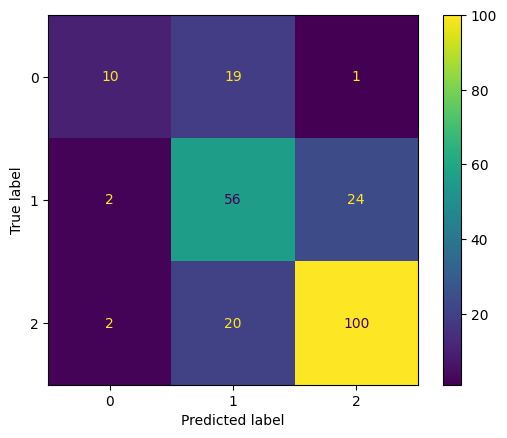

In [611]:

x_test = np.reshape(test_image,(len(test_label),pixel,pixel,channels))
y_test = np.reshape(test_label,(len(test_label),1))


y_prediction=combine_model.predict(x_test)
score = roc_auc_score(y_test, y_prediction, multi_class='ovr')
print("roc_auc_score:", score)
y_prediction = np.argmax(y_prediction, axis=1)
print("f1_score:", f1_score(y_test, y_prediction, average='weighted'))   
ac=accuracy_score(y_test, y_prediction)
print("accuracy_score:", ac)
print(classification_report(y_test, y_prediction))


combine_model.save('/mnt/louisayu/nfs_share2/embryo/model_weights1/g3/model/combine_'+str(ac).replace('0.','')+'.h5')
cm=confusion_matrix(y_test, y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [ ]:
for k in range(test.shape[0]):
    filename= "/mnt/louisayu/nfs_share2/embryo/pubdata/"+test['Image'][k]
      
    im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im,(pixel,pixel))
    im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
    img = img_to_array(im)
    print(np.argmax(model.predict(np.reshape(img,(1,pixel,pixel,channels)))))


In [ ]:
for k in range(test.shape[0]):
    filename= "/mnt/louisayu/nfs_share2/embryo/pubdata/"+test['Image'][k]
      
    im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im,(pixel,pixel))
    im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
    img = img_to_array(im)
    print(np.argmax(model.predict(np.reshape(img,(1,pixel,pixel,channels)))))


In [ ]:
for k in range(test.shape[0]):
    filename= "/mnt/louisayu/nfs_share2/embryo/pubdata/"+test['Image'][k]
      
    im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im,(pixel,pixel))
    im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
    img = img_to_array(im)
    print(np.argmax(combine_model.predict(np.reshape(img,(1,pixel,pixel,channels)))))
